# A/B-контест от samokat.tech  

## 1 Описание задачи

Распространённая и самая известная на рынке схема мошенничества: мошенник берёт данные ИНН из открытых источников, регистрирует на него компанию на площадке маркетплейса. Далее выставляет ходовой товар на продажу, например iPhone 14, на 50% дешевле рынка. Когда покупатель оформляет заказ на маркетплейсе, продавец пишет покупателю, что у него есть другой сайт, где можно купить товар ещё дешевле. Покупатель соглашается и оплачивает заказ по ссылке продавца в обход площадки. После этого продавец пропадает. Покупатель остается без товара. Такие продавцы очень сильно портят репутацию маркетплейса, и необходимо их выявлять как можно быстрее, лучше всего в процессе регистрации.  

Для этого ML-команда предложила к использованию модель по автоопределению продавцов-мошенников, которую нам предлагается внедрить в процесс регистрации продавц  .

Мы хотим ввести новый функционал, но как data-driven компания не можем это сделать без тестирования и проверки качества новой функциональности через A/B-тест.

In [32]:
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import hashlib

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

import scipy.stats as st
from statsmodels.stats.proportion import proportion_confint

sns.set(font_scale=1.2)
sns.set_style("whitegrid")

## EDA

- registration_date: дата регистрации (дата получения мерчант айди, продавец зарегистрировался на площадке)
- activation_date: дата активации (продавец прошел все этапы регистрации и может продавать)- merchant_id: айди продавца
- type: форма организации бизнеса
- ind_frod: индекс мошенниа



In [33]:
df = pd.read_csv('samokat_data.csv', sep=';')

In [34]:
df.head()

,registration_date,activation_date,merchant_id,type,ind_frod
0,16.12.2023,24.12.2023,1,IE,0.0
1,05.09.2023,08.09.2023,2,IE,0.0
2,16.04.2023,22.04.2023,3,IE,0.0
3,23.12.2023,24.12.2023,4,IE,0.0
4,28.01.2023,NaN,5,IE,0.0


In [35]:
df.shape

(35000, 5)

In [36]:
df.dtypes

registration_date     object
activation_date       object
merchant_id            int64
type                  object
ind_frod             float64
dtype: object

Приведем registration_date и activation_date в формат даты

In [37]:
df['registration_date'] = pd.to_datetime(df['registration_date'], dayfirst=True)
df['activation_date'] = pd.to_datetime(df['activation_date'], dayfirst=True)

In [38]:
df.dtypes

registration_date    datetime64[ns]
activation_date      datetime64[ns]
merchant_id                   int64
type                         object
ind_frod                    float64
dtype: object

Проверим пропущенные значения

In [39]:
df.isna().sum()

registration_date        0
activation_date      14700
merchant_id              0
type                     0
ind_frod               700
dtype: int64

Проверим уникальные merchant_id

In [40]:
df.nunique()

registration_date      365
activation_date        380
merchant_id          35000
type                     2
ind_frod                 2
dtype: int64

Количество уникальных id совпадает с их количеством

### registration_date

In [41]:
df['registration_date'].min()

Timestamp('1970-01-01 00:00:00')

In [42]:
df['registration_date'].max()

Timestamp('2023-12-31 00:00:00')

Проверим пользователей с 1970 годом регистрации, вероятнее всего дата не записалась, т.к. 01-01-1970 = 0

In [43]:
df[(df['registration_date'] == df['registration_date'].min()) & (~df['activation_date'].isna())]

,registration_date,activation_date,merchant_id,type,ind_frod
2392,1970-01-01,2023-02-18,2393,IE,1.0
3599,1970-01-01,2023-07-11,3600,IE,0.0
3773,1970-01-01,2023-03-05,3774,IE,0.0
4263,1970-01-01,2023-06-27,4264,IE,0.0
4740,1970-01-01,2023-04-01,4741,IE,1.0
...,...,...,...,...,...
33436,1970-01-01,2023-08-19,33437,LLC,0.0
33781,1970-01-01,2023-06-12,33782,LLC,0.0
33942,1970-01-01,2023-08-13,33943,LLC,0.0
34008,1970-01-01,2023-12-30,34009,LLC,0.0


In [44]:
df[(df['registration_date'] == df['registration_date'].min()) & (df['activation_date'].isna())]

,registration_date,activation_date,merchant_id,type,ind_frod
142,1970-01-01,NaT,143,IE,0.0
298,1970-01-01,NaT,299,IE,0.0
2035,1970-01-01,NaT,2036,IE,0.0
2077,1970-01-01,NaT,2078,IE,0.0
2082,1970-01-01,NaT,2083,IE,0.0
...,...,...,...,...,...
34217,1970-01-01,NaT,34218,LLC,0.0
34396,1970-01-01,NaT,34397,LLC,0.0
34415,1970-01-01,NaT,34416,LLC,0.0
34517,1970-01-01,NaT,34518,LLC,0.0


In [45]:
df[(df['registration_date'] == df['registration_date'].min()) & (~df['activation_date'].isna())]

,registration_date,activation_date,merchant_id,type,ind_frod
2392,1970-01-01,2023-02-18,2393,IE,1.0
3599,1970-01-01,2023-07-11,3600,IE,0.0
3773,1970-01-01,2023-03-05,3774,IE,0.0
4263,1970-01-01,2023-06-27,4264,IE,0.0
4740,1970-01-01,2023-04-01,4741,IE,1.0
...,...,...,...,...,...
33436,1970-01-01,2023-08-19,33437,LLC,0.0
33781,1970-01-01,2023-06-12,33782,LLC,0.0
33942,1970-01-01,2023-08-13,33943,LLC,0.0
34008,1970-01-01,2023-12-30,34009,LLC,0.0


Построим распределение количества регистраций от месяца

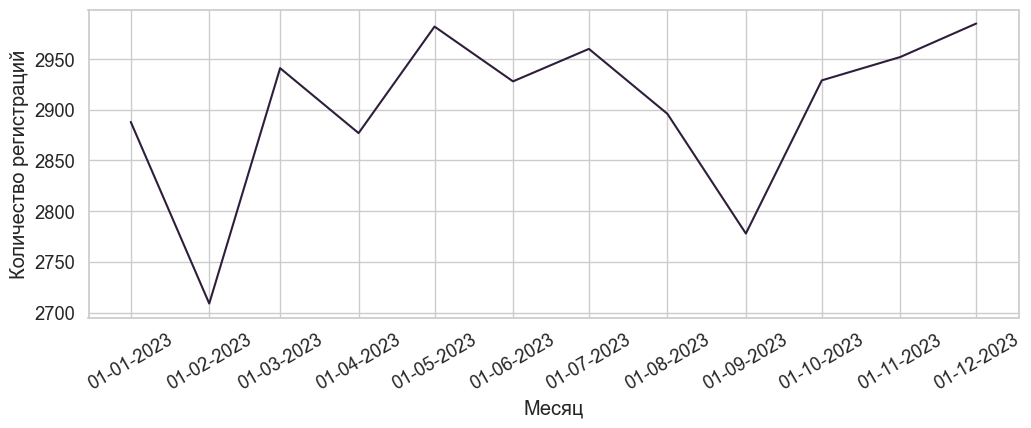

In [46]:
df['reg_start_of_month'] = df['registration_date'].apply(lambda x: x.replace(day=1))
reg_count_month = (df.groupby('reg_start_of_month', as_index=False)
                       .agg({'merchant_id': 'count'})
                       .sort_values('reg_start_of_month', ascending=True))

fig, ax = plt.subplots(figsize=(12, 4))

sns.lineplot(reg_count_month.query('reg_start_of_month != "1970-01-01"'),
             x='reg_start_of_month',
             y='merchant_id',
             color='#2e1e3b',
             ax=ax)
plt.setp(ax.get_xticklabels(), rotation=30)

ax.set(xlabel='Месяц',
       ylabel='Количество регистраций')

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
# axes[plot1].yaxis.set_major_formatter(ticker.EngFormatter())
# plt.savefig("reg_by_month.png") 

Пропущенных дат в registration_date нет, однако, присутствует 175 значений равных 01-01-1970. Данное значение соответствует нулю, можно предположить, что при регистрации произошел сбой и дата не записалась. Рассмотрим количество регистраций в месяц (за исключением 1970 года).

По данным видно, что выборка продавцов за 2023 год. Выделяются два месяца с малым количеством регистраций – февраль в большей степени и сентябрь в меньшей. Можно предположить, что именно в эти месяцы были регистрации с датой 01-01-1970. Если у данных пользователей есть дата активации между февралем и сентябрем проставим им февральскую дату регистрации, после августа – сентябрем. 

In [47]:
df['old_registration_date'] = df['registration_date']
df.loc[:, 'registration_date'][(df['registration_date'] == df['registration_date'].min())
    & (~df['activation_date'].isna())
    & (df['activation_date'] <= "2023-08-31")
    & (df['activation_date'] >= "2023-02-01")] = pd.to_datetime('2023-02-01')

C:\Users\nikit\AppData\Local\Temp\ipykernel_13792\359373628.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'registration_date'][(df['registration_date'] == df['registration_date'].min())


In [48]:
df[(df['registration_date'] == df['registration_date'].min())
    & (~df['activation_date'].isna())
    & (df['activation_date'] <= "2023-08-31")
    & (df['activation_date'] >= "2023-02-01")]

,registration_date,activation_date,merchant_id,type,ind_frod,reg_start_of_month,old_registration_date


In [49]:
df.loc[:, 'registration_date'][(df['registration_date'] == df['registration_date'].min())
    & (~df['activation_date'].isna())
    & (df['activation_date'] > "2023-08-31")] = pd.to_datetime('2023-09-01')

C:\Users\nikit\AppData\Local\Temp\ipykernel_13792\3541107813.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'registration_date'][(df['registration_date'] == df['registration_date'].min())


In [50]:
df[(df['registration_date'] == df['registration_date'].min())
    & (~df['activation_date'].isna())
    & (df['activation_date'] > "2023-08-31")]

,registration_date,activation_date,merchant_id,type,ind_frod,reg_start_of_month,old_registration_date


In [51]:
df[(df['registration_date'] == df['registration_date'].min())]

,registration_date,activation_date,merchant_id,type,ind_frod,reg_start_of_month,old_registration_date
142,1970-01-01,NaT,143,IE,0.0,1970-01-01,1970-01-01
298,1970-01-01,NaT,299,IE,0.0,1970-01-01,1970-01-01
2035,1970-01-01,NaT,2036,IE,0.0,1970-01-01,1970-01-01
2077,1970-01-01,NaT,2078,IE,0.0,1970-01-01,1970-01-01
2082,1970-01-01,NaT,2083,IE,0.0,1970-01-01,1970-01-01
...,...,...,...,...,...,...,...
34217,1970-01-01,NaT,34218,LLC,0.0,1970-01-01,1970-01-01
34396,1970-01-01,NaT,34397,LLC,0.0,1970-01-01,1970-01-01
34415,1970-01-01,NaT,34416,LLC,0.0,1970-01-01,1970-01-01
34517,1970-01-01,NaT,34518,LLC,0.0,1970-01-01,1970-01-01


Пользователей с registration_date = 01-01-1970 и без даты активации уберем из выборки (90 шт).

In [52]:
df = df.drop(index=df[(df['registration_date'] == df['registration_date'].min())].index)

Построим распределение количества регистраций от месяца после изменения данных

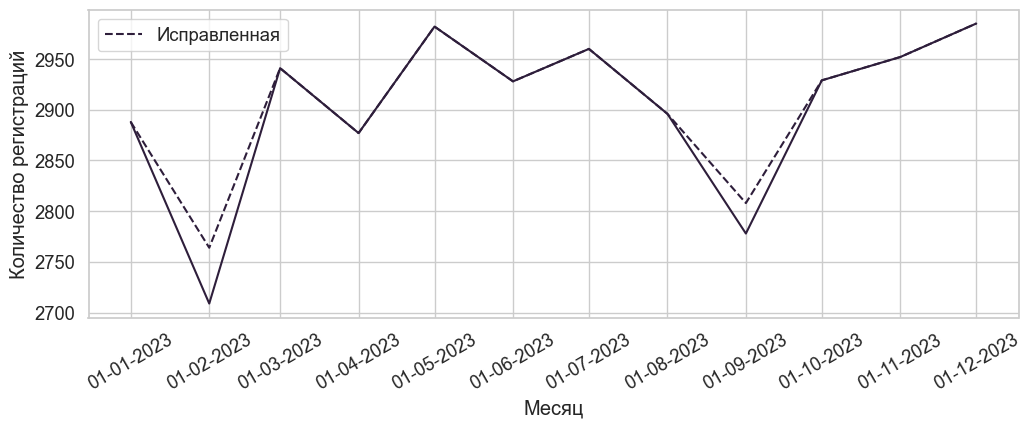

In [53]:
df['reg_start_of_month'] = df['registration_date'].apply(lambda x: x.replace(day=1))
reg_count_month_new = (df.groupby('reg_start_of_month', as_index=False)
                       .agg({'merchant_id': 'count'})
                       .sort_values('reg_start_of_month', ascending=True))


fig, ax = plt.subplots(figsize=(12, 4))

sns.lineplot(reg_count_month_new.query('reg_start_of_month != "1970-01-01"'),
             x='reg_start_of_month',
             y='merchant_id',
             color='#2e1e3b',
             ax=ax,
             label='Исправленная',
             linestyle="--")
sns.lineplot(reg_count_month.query('reg_start_of_month != "1970-01-01"'),
             x='reg_start_of_month',
             y='merchant_id',
             color='#2e1e3b',
             ax=ax)
plt.setp(ax.get_xticklabels(), rotation=30)

ax.set(xlabel='Месяц',
       ylabel='Количество регистраций')

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
# plt.savefig("reg_by_month.png") 

### activation_date

In [54]:
df['activ_start_of_month'] = df['activation_date'].apply(lambda x: x.replace(day=1))

In [56]:
df.query('activation_date == "1970-01-01"')

,registration_date,activation_date,merchant_id,type,ind_frod,reg_start_of_month,old_registration_date,activ_start_of_month


In [59]:
df[df['activation_date'].isna()].shape

(14611, 8)

Дат активаций 1970 годов нет. 14701 значение без даты (после удаления в прошлом шаге 90 строк, осталось 14611). 

Построим распределение количества активаций от месяца

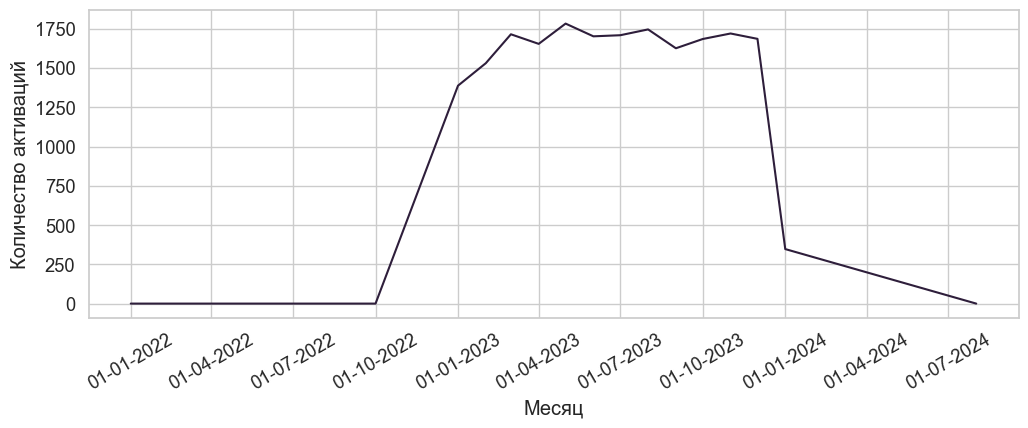

In [61]:
df['activ_start_of_month'] = df['activation_date'].apply(lambda x: x.replace(day=1))
activ_count_month = (df.groupby('activ_start_of_month', as_index=False)
                       .agg({'merchant_id': 'count'})
                       .sort_values('activ_start_of_month', ascending=True))


fig, ax = plt.subplots(figsize=(12, 4))
# fig.suptitle()

# ax.title.set_text('DAU за последний месяц')

sns.lineplot(activ_count_month,
             x='activ_start_of_month',
             y='merchant_id',
             color='#2e1e3b',
             ax=ax)
plt.setp(ax.get_xticklabels(), rotation=30)

ax.set(xlabel='Месяц',
       ylabel='Количество активаций')

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
# axes[plot1].yaxis.set_major_formatter(ticker.EngFormatter())
plt.savefig("activ_by_month.png")

In [62]:
df.loc[:, 'activation_date'][df['activation_date'] <= "2023-01-01"]

1007    2022-06-03
5249    2022-02-23
31191   2022-01-22
33774   2022-05-20
34995   2022-10-31
Name: activation_date, dtype: datetime64[ns]

In [63]:
df.query('activation_date < "2023-01-01"').iloc[:, 1].apply(lambda x: x.replace(year=2023))

1007    2023-06-03
5249    2023-02-23
31191   2023-01-22
33774   2023-05-20
34995   2023-10-31
Name: activation_date, dtype: datetime64[ns]

Имеются 5 пользователей с активацией в 2022 году, исправим год на 2023, тогда хронология сохраняется (активация после регистрации). 

In [64]:
(df.loc[:, 'activation_date']
   [df['activation_date'] <= "2023-01-01"]) = (df.query('activation_date < "2023-01-01"')
                                                 .iloc[:, 1]
                                                 .apply(lambda x: x.replace(year=2023)))

C:\Users\nikit\AppData\Local\Temp\ipykernel_13792\2915047398.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  (df.loc[:, 'activation_date']


In [65]:
df.query('activation_date < "2023-01-01"')

,registration_date,activation_date,merchant_id,type,ind_frod,reg_start_of_month,old_registration_date,activ_start_of_month


Количество активаций после 2023 года

In [73]:
df.query('activation_date > "2023-12-31"').shape

(349, 8)

In [67]:
df.shape

(34910, 8)

Удалим записи, где нарушена хронология - дата регистрации после активации (записей всего 14 штук)

In [68]:
df = df.drop(index=df[df['registration_date'] > df['activation_date']].index)

In [69]:
df[df['registration_date'] > df['activation_date']]

,registration_date,activation_date,merchant_id,type,ind_frod,reg_start_of_month,old_registration_date,activ_start_of_month


In [70]:
df[df['registration_date'] > df['activation_date']].shape

(0, 8)

In [71]:
df.shape

(34896, 8)

Построим распределение количества активаций от месяца после изменения данных

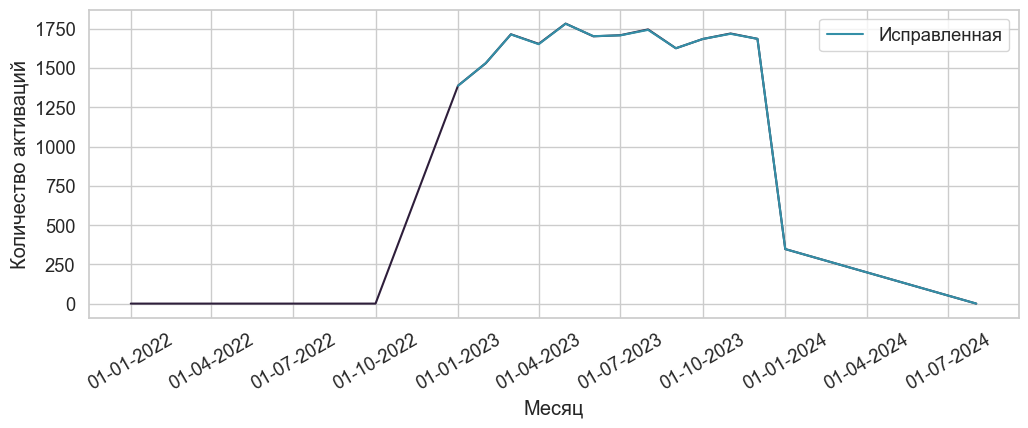

In [72]:
df['activ_start_of_month'] = df['activation_date'].apply(lambda x: x.replace(day=1))
activ_count_month_new = (df.groupby('activ_start_of_month', as_index=False)
                       .agg({'merchant_id': 'count'})
                       .sort_values('activ_start_of_month', ascending=True))


fig, ax = plt.subplots(figsize=(12, 4))

sns.lineplot(activ_count_month,
             x='activ_start_of_month',
             y='merchant_id',
             color='#2e1e3b',
             ax=ax)
sns.lineplot(activ_count_month_new,
             x='activ_start_of_month',
             y='merchant_id',
             color='#348fa7',
             ax=ax,
             label='Исправленная',
             linestyle="-")
plt.setp(ax.get_xticklabels(), rotation=30)

ax.set(xlabel='Месяц',
       ylabel='Количество активаций')

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
# plt.savefig("activ_by_month.png") 

## merchant_id, type, ind_frod

In [76]:
df.head()

,registration_date,activation_date,merchant_id,type,ind_frod,reg_start_of_month,old_registration_date,activ_start_of_month
0,2023-12-16,2023-12-24,1,IE,0.0,2023-12-01,2023-12-16,2023-12-01
1,2023-09-05,2023-09-08,2,IE,0.0,2023-09-01,2023-09-05,2023-09-01
2,2023-04-16,2023-04-22,3,IE,0.0,2023-04-01,2023-04-16,2023-04-01
3,2023-12-23,2023-12-24,4,IE,0.0,2023-12-01,2023-12-23,2023-12-01
4,2023-01-28,NaT,5,IE,0.0,2023-01-01,2023-01-28,NaT


In [77]:
df.shape

(34896, 8)

In [78]:
df['merchant_id'].nunique()

34896

In [79]:
df['type'].unique()

array(['IE', 'LLC'], dtype=object)

In [80]:
df.isna().sum()

registration_date            0
activation_date          14611
merchant_id                  0
type                         0
ind_frod                   699
reg_start_of_month           0
old_registration_date        0
activ_start_of_month     14611
dtype: int64

In [81]:
df['ind_frod'].unique()

array([ 0., nan,  1.])

In [84]:
sum(df['ind_frod'] == 1)

2819

In [85]:
df['ind_frod'].sum()

2819.0

In [86]:
df['ind_frod'].sum() / df.shape[0]

0.08078289775332416

In [87]:
df.loc[df['activation_date'].isna()]['ind_frod'].sum()

1211.0

In [88]:
df.shape

(34896, 8)

Удалим пользователей с ind_frod = NaN

In [89]:
df = df.drop(index=df.loc[df['ind_frod'].isna()].index)

In [90]:
df.shape

(34197, 8)

In [91]:
df = df.drop(columns=['old_registration_date'])

In [92]:
df.groupby(['type', 'ind_frod'], as_index=False).agg({'merchant_id': 'count'})

,type,ind_frod,merchant_id
0,IE,0.0,22275
1,IE,1.0,2369
2,LLC,0.0,9103
3,LLC,1.0,450


In [93]:
df[~df['activation_date'].isna()].groupby(['type', 'ind_frod'], as_index=False).agg({'merchant_id': 'count'})

,type,ind_frod,merchant_id
0,IE,0.0,12949
1,IE,1.0,1368
2,LLC,0.0,5329
3,LLC,1.0,240


In [94]:
frod_ratio = df['ind_frod'].sum() / df.shape[0]
frod_ratio

0.08243413164897506

In [95]:
df.shape[0]

34197

In [96]:
df['ind_frod'].sum()

2819.0

После предыдущих шагов обработки осталось 34896 строк.      
Все значения merchant_id уникальны, пропусков нет.       
Колонка type включает только два показателя: IE и LLC, пропусков нет.       
ind_frod включает 699 не определенных значений, 2819 мошенников, 31378 нормальных продавцов.       
Так как 699 пользователей не прошли онбординг и мы не можем оценить их принадлежность к мошенникам (ind_frod = NaN), данных продавцов исключим из выборки.      
Итоговый датафрейм содержит 34197 строк. Из них 8,24% продавцов определены, как мошенники.     


### Определение гипотезы и метрик
Гипотеза:
- модель по автоопределению продавцов-мошенников с большей вероятностью определяет мошенника.
Метрики:
- core-метрика: доля мошенников. Модель должна, как минимум, не хуже ручной проверки определять продавца, как мошенника. Однако, нас будет интересовать тот факт, что модель работает лучше.
- warning-метрика: количество регистраций. Возможно, модель будет определять добросовестных продавцов, как мошенников, соответственно, будет проблематично зарегистрироваться. Ожидаем, что количество регистраций не изменится.
- proxy-метрика: доля мошенников до активации продавца. Если общая доля мошенников не будет отличаться от контрольной группы, возможно, что модель лучше определяет мошенников именно на этапе регистрации, что является ее преимуществом, так как продавец не успевает выйти на площадку и испортить репутацию маркетплейса. Возможно, стоит отдельно рассмотреть ООО и ИП, так как они отличаются по доле обнаруженных мошенников.
- Зафиксируем стандартные значения α = 0,05, β = 0,2 и мощности = (1 – β) = 0,8. 0,8.


### А/А

Разделим пользователей на группы с помощью хеширования с солью и проведем A/A тест

In [97]:
def ab_split(id, salt='frod', n_groups=2):
    test_id = str(id) + str(salt)
    test_id_digest = hashlib.md5(test_id.encode('ascii')).hexdigest()
    test_id_final_int = int(test_id_digest, 16)
    return test_id_final_int % n_groups

In [98]:
df['group'] = df['merchant_id'].apply(lambda x: ab_split(x))

In [99]:
df.groupby('group', as_index=False)['merchant_id'].count()

,group,merchant_id
0,0,17186
1,1,17011


In [100]:
df.groupby(['group', 'type'], as_index=False)['merchant_id'].count()

,group,type,merchant_id
0,0,IE,12524
1,0,LLC,4662
2,1,IE,12120
3,1,LLC,4891


In [101]:
df[(df['group'] == 0)]['ind_frod'].mean()

0.08373094379145817

In [102]:
df[(df['group'] == 1)]['ind_frod'].mean()

0.08112397860208101

In [103]:
(df[(df['group'] == 1)]['ind_frod'].mean() - df[(df['group'] == 0)]['ind_frod'].mean()) / df[(df['group'] == 0)]['ind_frod'].mean()

-0.031135026924694786

Пусть:     
0 – контрольная группа (17186 продавцов: IE = 12524, LLC = 4662)     
1 – тестовая (17011 продавцов: IE = 12120, LLC = 4891)     
Выборки получились схожие по размеру.     
Доля мошенников в контрольной группе = 8,37%, в тестовой = 8,11%.

In [104]:
def simaltion_AA (group_1, group_2, sample_length = 1500, number_of_samples = 10000):
    '''
    Функция simaltion_AA:
    Симуляция 10000 А/А-тестов. На каждой итерации формируется подвыборка без повторения в 1500 юзеров из двух групп.
    Проводятся сравнения этих подвыборок t-testом.
    Выводятся:
    1. Какой процент p-values оказался меньше либо равен 0.05
    2. Гистограмма распределения получившихся 10000 p-values.
    '''

    samples_group_1 = [group_1.sample(sample_length).tolist() for i in range(number_of_samples)]
    samples_group_2 = [group_2.sample(sample_length).tolist() for i in range(number_of_samples)]
    
    p_values = st.ttest_ind(samples_group_1,
                            samples_group_2,
                            equal_var=False,
                            axis=1)[1]
    
    sns.histplot(p_values, color='#2e1e3b')
    
    p = round((p_values[p_values <= 0.05].size / p_values.size) * 100, 2)
    ci = proportion_confint(count = p_values[p_values <= 0.05].size, nobs = number_of_samples, alpha=0.05, method='wilson')
    print(f'Процент p-values меньше либо равных 0.05: {p}% \n')
    print(f'Доверительный интервал: {ci}')

Процент p-values меньше либо равных 0.05: 4.9% 

Доверительный интервал: (0.044939516707863926, 0.053406849822486356)


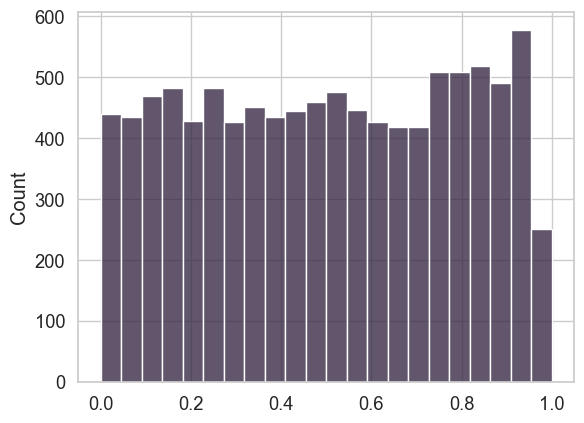

In [106]:
# Запустим симуялцию для всех данных
group_0 = df[(df['group'] == 0)]['ind_frod']
group_1 = df[(df['group'] == 1)]['ind_frod']

simaltion_AA(group_0, group_1, 1500, 10000)

Смоделируем биноминальное распределение:
- размеры выборок равные количеству регистраций в июне для каждой группы
- вероятность посчитаем за год для каждой группы отдельно

In [126]:
group_0_june = df[(df['reg_start_of_month'] == '2023-06-01') & (df['group'] == 0)]
group_1_june = df[(df['reg_start_of_month'] == '2023-06-01') & (df['group'] == 1)]

In [127]:
binom_control = st.binom(n=group_0_june.shape[0], p=group_0.mean())
binom_test = st.binom(n=group_1_june.shape[0], p=group_1.mean())

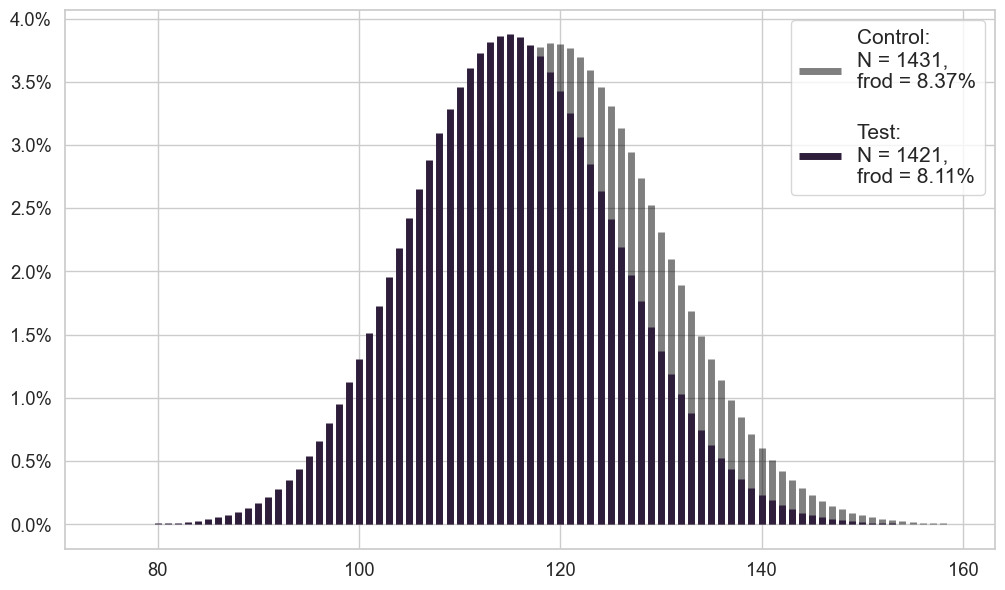

In [128]:
x_grid = np.arange(75, 160)

fig, ax = plt.subplots(figsize=(12, 7))

# строим распределение при H0 и критическую область
probs_h0 = binom_control.pmf(x_grid)
ax.vlines(x_grid, 0, probs_h0, color='black', linewidth=5.0, label=f'Control:\nN = {group_0_june.shape[0]},\nfrod = {group_0.mul(100).mean().round(2)}%\n', alpha=0.5)

# строим распределение при mu > 0.5
probs_alternative = binom_test.pmf(x_grid)
ax.vlines(x_grid, 0, probs_alternative, color='#2e1e3b', linewidth=5.0, label=f'Test: \nN = {group_1_june.shape[0]},\nfrod = {group_1.mul(100).mean().round(2)}%')

# plt.title('Биноминальное распределение с реальными характеристиками', fontsize=20)
ax.legend(fontsize=15)
ax.yaxis.set_major_formatter(ticker.PercentFormatter(1.0, decimals=1))
# plt.show()

### Определение MDE и сроков проведения эксперимента

In [129]:
def get_stat_power(N_h0, N_h1, mu_h0, mu_h1, alpha):
    '''Вычисляет статистическую мощность критерия для биномиального распределения
    
    Параметры:
        N - количество бернуллиевских экспериментов (размер выборки)
        mu_h0 - вероятность успеха в нулевой гипотезе
        mu_alternative - предполагаемая вероятность успеха в эксперименте
        alpha - уровень значимости критерия
    '''
    binom_control = st.binom(n=N_h0, p=mu_h0)
    binom_test = st.binom(n=N_h1, p=mu_h1)

    # вычисляем критическое значение
    critical_value = binom_control.ppf(1 - alpha) + 1
    # вычисляем мощность по формуле
    return 1 - binom_test.cdf(critical_value - 1) 

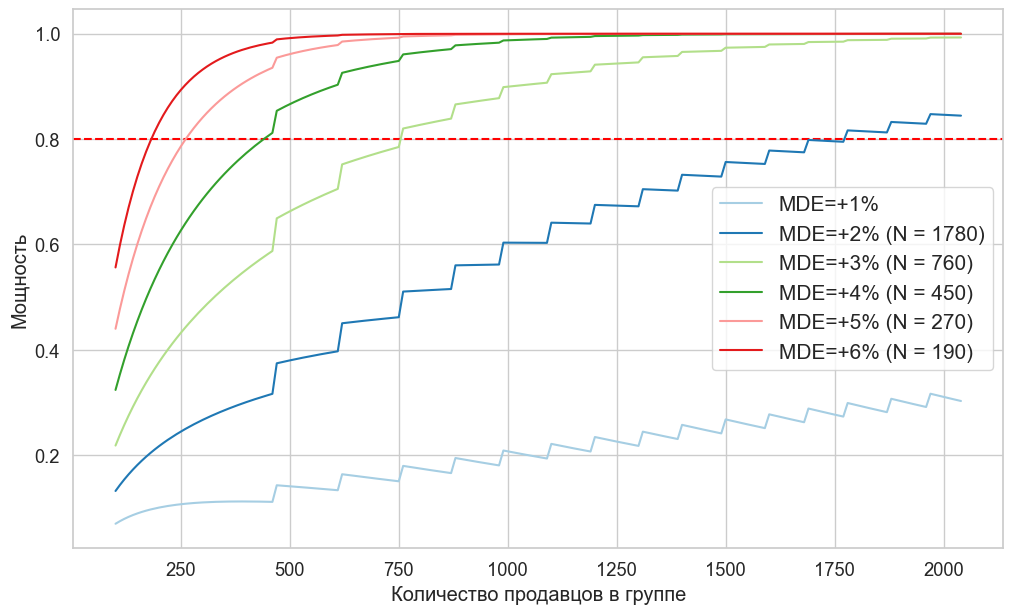

<Figure size 1200x700 with 0 Axes>

In [145]:
n_grid = np.arange(100, 2050, 10)
n_eff = np.arange(group_1.mean() + 0.01, 0.15, 0.01)
# можем вычислить 
sns.set_palette('Paired')
fig, ax = plt.subplots(figsize=(12, 7))
plt.figure(figsize=(12, 7))
ax.axhline(0.8, ls='--', color='red')
ax.set(xlabel='Количество продавцов в группе',
       ylabel='Мощность')
for eff in n_eff:
    power = get_stat_power(n_grid, n_grid, group_0.mean(), eff, alpha=0.05)
    # считаем минимальный размер выборки для мощности в 80% 
    try:
        size = n_grid[power >= 0.8].min()
        sns.lineplot(x=n_grid, y=power, ax=ax, label=f'MDE=+{round((eff - group_1.mean()) * 100)}% (N = {size})')
        ax.legend(fontsize=15)
    except:
        sns.lineplot(x=n_grid, y=power, ax=ax, label=f'MDE=+{round((eff - group_1.mean()) * 100)}%')
        ax.legend(fontsize=15)

**С поправкой на неравенство в группах**

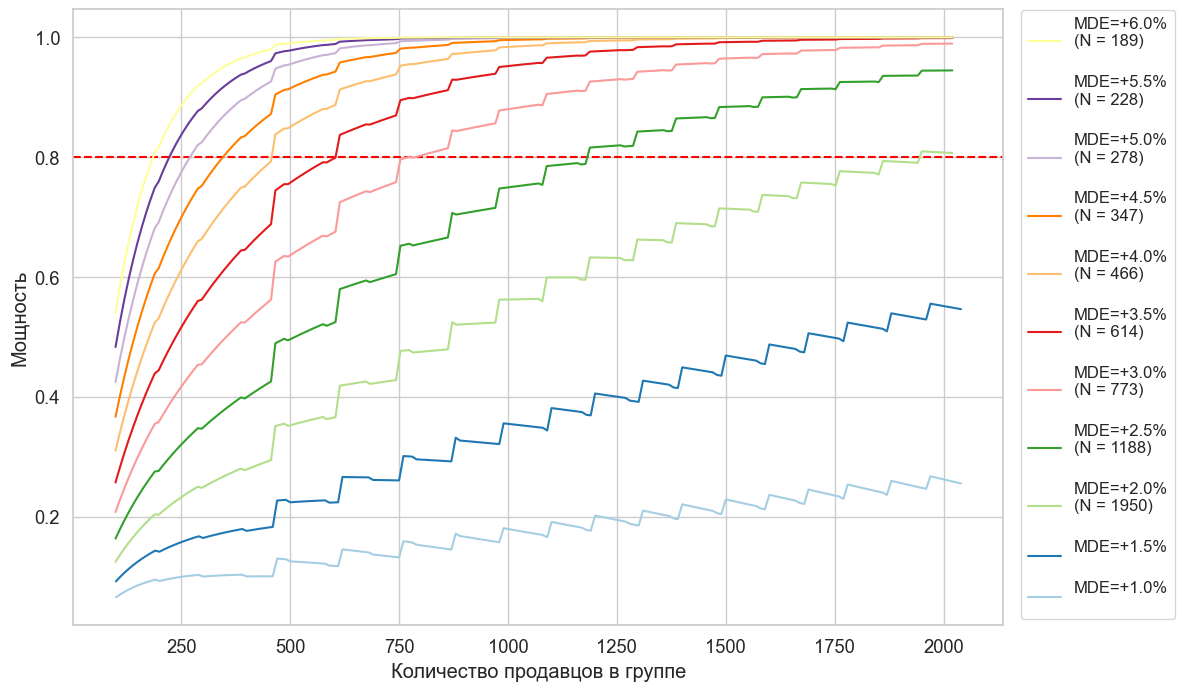

In [146]:
diff_group_coeff = df[(df['group'] == 1)].shape[0] / df[(df['group'] == 0)].shape[0]
n_grid_h0 = np.arange(100, 2050, 10)
n_grid_h1 = np.ceil(n_grid_h0 * diff_group_coeff)
n_eff = np.arange(group_1.mean() + 0.01, 0.145, 0.005)
# можем вычислить 
sns.set_palette('Paired')
fig, ax = plt.subplots(figsize=(12, 8))
ax.axhline(0.8, ls='--', color='red')
ax.set(xlabel='Количество продавцов в группе',
       ylabel='Мощность')
# ax.yaxis.set_major_formatter(ticker.PercentFormatter())
min_days = []
for eff in n_eff:
    power = get_stat_power(n_grid_h0, n_grid_h1, group_0.mean(), eff, alpha=0.05)
    # считаем минимальный размер выборки для мощности в 80% 
    try:
        size = int(n_grid_h1[power >= 0.8].min())
        min_days.append(size)
        sns.lineplot(x=n_grid_h1,
                     y=power,
                     ax=ax,
                     label=f'MDE=+{round((eff - group_1.mean()) * 100, 2)}%\n(N = {size})\n')
        ax.legend(fontsize=15)
    except:
        sns.lineplot(x=n_grid,
                     y=power,
                     ax=ax,
                     label=f'MDE=+{round((eff - group_1.mean()) * 100,2)}%\n')
        ax.legend(fontsize=15)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.01, 1.013), loc='upper left', prop={'size': 12})

In [138]:
count = 1.5
week_reg = 290
for days in min_days:
    count += 0.5
    print(f'MDE = {8.1 + count}% (+{count}), длительность A/B-теста: {round(days / week_reg, 1)} недель')

MDE = 10.1% (+2.0), длительность A/B-теста: 6.7 недель
MDE = 10.6% (+2.5), длительность A/B-теста: 4.1 недель
MDE = 11.1% (+3.0), длительность A/B-теста: 2.7 недель
MDE = 11.6% (+3.5), длительность A/B-теста: 2.1 недель
MDE = 12.1% (+4.0), длительность A/B-теста: 1.6 недель
MDE = 12.6% (+4.5), длительность A/B-теста: 1.2 недель
MDE = 13.1% (+5.0), длительность A/B-теста: 1.0 недель
MDE = 13.6% (+5.5), длительность A/B-теста: 0.8 недель
MDE = 14.1% (+6.0), длительность A/B-теста: 0.7 недель


In [149]:
min_days

[1950, 1188, 773, 614, 466, 347, 278, 228, 189]

### Расчеты для пользователей без активации

Процент p-values меньше либо равных 0.05: 4.48% 

Доверительный интервал: (0.040917336190577636, 0.04903225592608633)


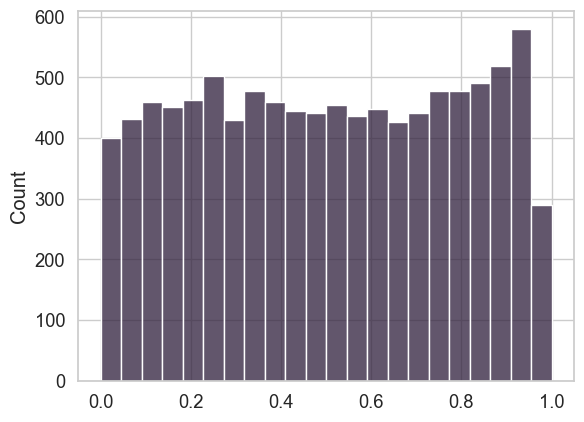

In [150]:
# Подготовим данные для функции и вызовем ее
group_0_wo_activation = df[(df['group'] == 0) & (df['activation_date'].isna())]['ind_frod']
group_1_wo_activation = df[(df['group'] == 1) & (df['activation_date'].isna())]['ind_frod']

simaltion_AA(group_0_wo_activation, group_1_wo_activation, 1500, 10000)

Смоделируем биноминальное распределение:
- размеры выборок равные количеству регистраций в июне для каждой группы
- вероятность посчитаем за год для каждой группы отдельно

In [151]:
binom_control_wo = st.binom(n=group_0_june.shape[0], p=group_0_wo_activation.mean())
binom_test_wo = st.binom(n=group_1_june.shape[0], p=group_1_wo_activation.mean())

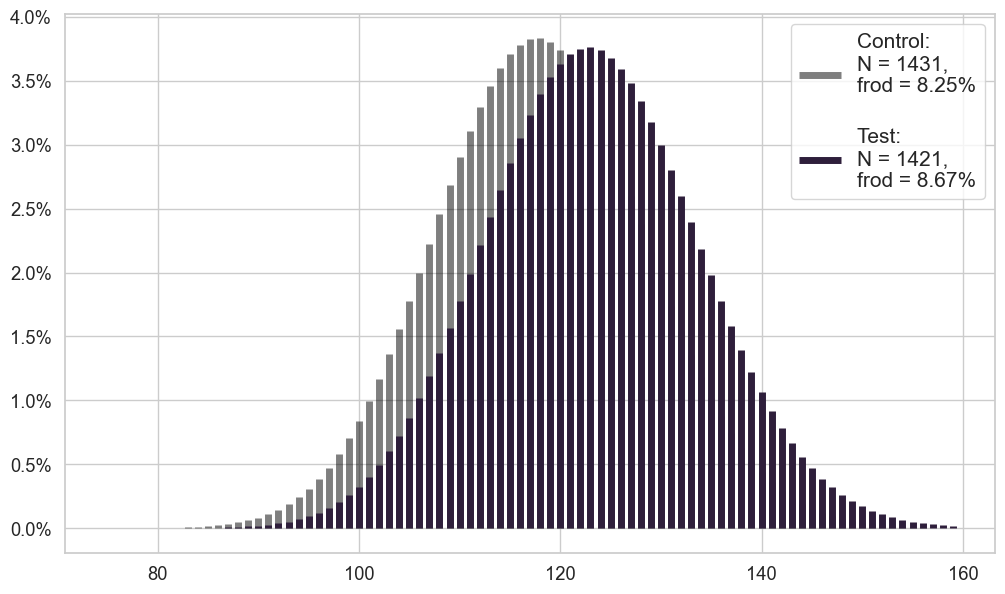

In [152]:
x_grid = np.arange(75, 160)

fig, ax = plt.subplots(figsize=(12, 7))

# строим распределение при H0 и критическую область
probs_h0 = binom_control_wo.pmf(x_grid)
ax.vlines(x_grid, 0, probs_h0, color='black', linewidth=5.0, label=f'Control:\nN = {group_0_june.shape[0]},\nfrod = {group_0_wo_activation.mul(100).mean().round(2)}%\n', alpha=0.5)

# строим распределение при mu > 0.5
probs_alternative = binom_test_wo.pmf(x_grid)
ax.vlines(x_grid, 0, probs_alternative, color='#2e1e3b', linewidth=5.0, label=f'Test: \nN = {group_1_june.shape[0]},\nfrod = {group_1_wo_activation.mul(100).mean().round(2)}%')

# plt.title('Биноминальное распределение с реальными характеристиками', fontsize=20)
ax.legend(fontsize=15)
ax.yaxis.set_major_formatter(ticker.PercentFormatter(1.0, decimals=1))
# plt.show()

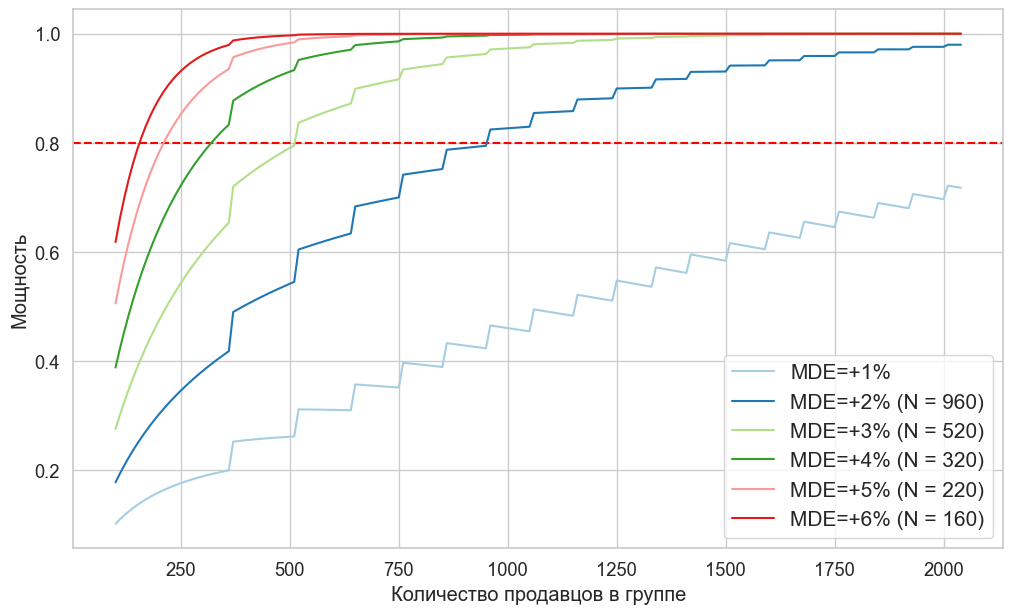

<Figure size 1200x700 with 0 Axes>

In [153]:
n_grid = np.arange(100, 2050, 10)
n_eff = np.arange(group_1_wo_activation.mean() + 0.01, 0.15, 0.01)
# можем вычислить 
sns.set_palette('Paired')
fig, ax = plt.subplots(figsize=(12, 7))
plt.figure(figsize=(12, 7))
ax.axhline(0.8, ls='--', color='red')
ax.set(xlabel='Количество продавцов в группе',
       ylabel='Мощность')
for eff in n_eff:
    power = get_stat_power(n_grid, n_grid, group_0_wo_activation.mean(), eff, alpha=0.05)
    # считаем минимальный размер выборки для мощности в 80% 
    try:
        size = n_grid[power >= 0.8].min()
        sns.lineplot(x=n_grid, y=power, ax=ax, label=f'MDE=+{round((eff - group_1_wo_activation.mean()) * 100)}% (N = {size})')
        ax.legend(fontsize=15)
    except:
        sns.lineplot(x=n_grid, y=power, ax=ax, label=f'MDE=+{round((eff - group_1_wo_activation.mean()) * 100)}%')
        ax.legend(fontsize=15)

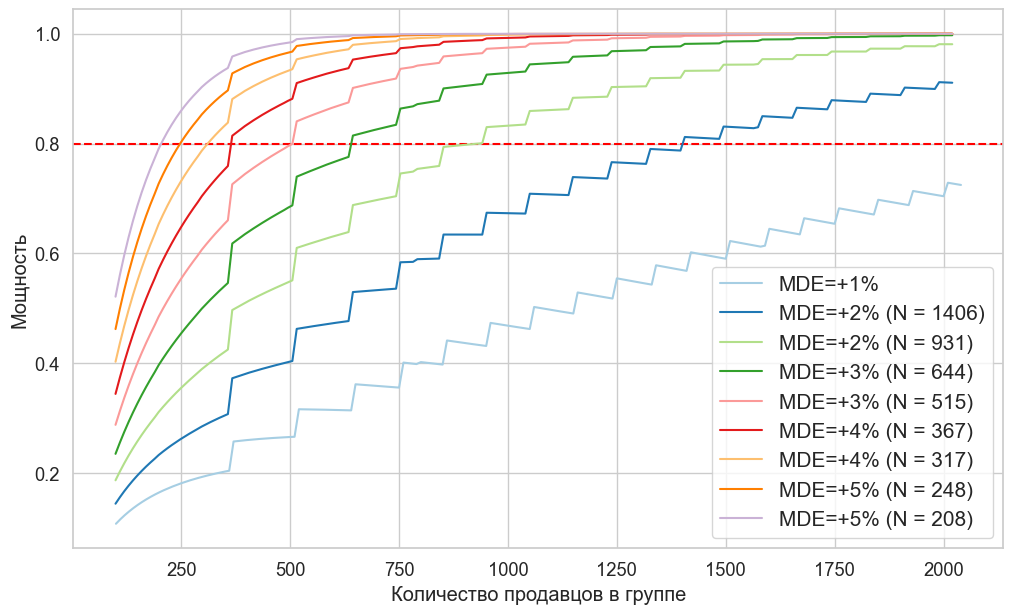

<Figure size 1200x700 with 0 Axes>

In [155]:
diff_group_coeff = df[(df['group'] == 0) & (df['activation_date'].isna())].shape[0] / df[(df['group'] == 1) & (df['activation_date'].isna())].shape[0]
n_grid_h0_wo = np.arange(100, 2050, 10)
n_grid_h1_wo = np.ceil(n_grid_h0 * diff_group_coeff)
n_eff = np.arange(group_1_wo_activation.mean() + 0.01, 0.14, 0.005)
# можем вычислить 
sns.set_palette('Paired')
fig, ax = plt.subplots(figsize=(12, 7))
plt.figure(figsize=(12, 7))
ax.axhline(0.8, ls='--', color='red')
ax.set(xlabel='Количество продавцов в группе',
       ylabel='Мощность')
# ax.yaxis.set_major_formatter(ticker.PercentFormatter())
for eff in n_eff:
    power = get_stat_power(n_grid_h0_wo, n_grid_h1_wo, group_0_wo_activation.mean(), eff, alpha=0.05)
    # считаем минимальный размер выборки для мощности в 80% 
    try:
        size = int(n_grid_h1[power >= 0.8].min())
        sns.lineplot(x=n_grid_h1, y=power, ax=ax, label=f'MDE=+{round((eff - group_1_wo_activation.mean()) * 100)}% (N = {size})')
        ax.legend(fontsize=15)
    except:
        sns.lineplot(x=n_grid, y=power, ax=ax, label=f'MDE=+{round((eff - group_1_wo_activation.mean()) * 100)}%')
        ax.legend(fontsize=15)

### Посчитаем сколько продавцов регистрируется на маркетплейсе в неделю

In [161]:
df['reg_start_of_week'] = df['registration_date'].dt.to_period('W').apply(lambda r: r.start_time)

In [163]:
# sns.histplot(df.query('group == 0').groupby('reg_start_of_week').agg({'merchant_id': 'count'})['merchant_id'],
#              color='#2e1e3b',
#              label='Контроль',
#              legend=True, bins=20)
# sns.histplot(df.query('group == 1').groupby('reg_start_of_week').agg({'merchant_id': 'count'})['merchant_id'],
#              color='#40b7ad',
#              label='Тест', bins=20)

<Axes: xlabel='merchant_id', ylabel='Count'>

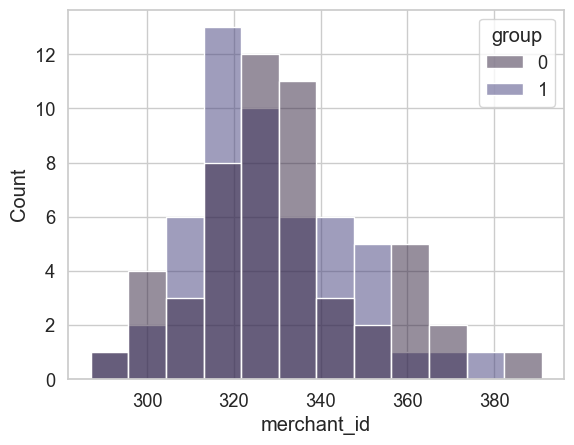

In [166]:
sns.set_palette('mako')
sns.histplot(data=df.groupby(['group', 'reg_start_of_week'], as_index=False).agg({'merchant_id': 'count'}),
             x='merchant_id',
             hue='group',
             color='#40b7ad',
             label='Тест',
             bins=12)

In [167]:
df.query('group == 0').groupby('reg_start_of_week').agg({'merchant_id': 'count'}).describe()

,merchant_id
count,52.000000
mean,330.500000
std,19.918953
min,288.000000
25%,318.250000
50%,328.500000
75%,338.750000
max,391.000000


In [168]:
df.query('group == 0').groupby('reg_start_of_week').agg({'merchant_id': 'count'}).std() * 2

merchant_id    39.837907
dtype: float64

In [169]:
(df.query('group == 0').groupby('reg_start_of_week').agg({'merchant_id': 'count'}).mean()
- 2 * df.query('group == 0').groupby('reg_start_of_week').agg({'merchant_id': 'count'}).std())

merchant_id    290.662093
dtype: float64

In [170]:
(df.query('group == 0').groupby('reg_start_of_week').agg({'merchant_id': 'count'}).mean()
+ 2 * df.query('group == 0').groupby('reg_start_of_week').agg({'merchant_id': 'count'}).std())

merchant_id    370.337907
dtype: float64

In [171]:
df.query('group == 1').groupby('reg_start_of_week').agg({'merchant_id': 'count'}).describe()

,merchant_id
count,52.000000
mean,327.134615
std,18.238108
min,287.000000
25%,315.000000
50%,325.500000
75%,339.250000
max,378.000000


In [172]:
df.query('group == 1').groupby('reg_start_of_week').agg({'merchant_id': 'count'}).std() * 2

merchant_id    36.476216
dtype: float64

In [173]:
df.query('group == 1').groupby('reg_start_of_week').agg({'merchant_id': 'count'}).mean() - df.query('group == 1').groupby('reg_start_of_week').agg({'merchant_id': 'count'}).std() * 2

merchant_id    290.658399
dtype: float64

Среднее количество регистраций в неделю в контрольной группе = 330,5 ± 39,9 (±2σ).

Среднее количество регистраций в неделю в тестовой группе = 327,1 ± 36,5 (±2σ).

Рассмотрим худший случай, когда у нас будет минимальное количество регистраций каждую неделю: тестовая - 2σ = 290 регистраций

In [174]:
count = 1.5
week_reg = 290
for days in min_days:
    count += 0.5
    print(f'MDE = {8.1 + count}% (+{count}), длительность A/B-теста: {round(days / week_reg, 1)} недель')

MDE = 10.1% (+2.0), длительность A/B-теста: 6.7 недель
MDE = 10.6% (+2.5), длительность A/B-теста: 4.1 недель
MDE = 11.1% (+3.0), длительность A/B-теста: 2.7 недель
MDE = 11.6% (+3.5), длительность A/B-теста: 2.1 недель
MDE = 12.1% (+4.0), длительность A/B-теста: 1.6 недель
MDE = 12.6% (+4.5), длительность A/B-теста: 1.2 недель
MDE = 13.1% (+5.0), длительность A/B-теста: 1.0 недель
MDE = 13.6% (+5.5), длительность A/B-теста: 0.8 недель
MDE = 14.1% (+6.0), длительность A/B-теста: 0.7 недель
